In [135]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
import interflow.realnvp as realnvp
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No CUDA device found!
cpu
Torch version: 2.7.1


## Adversarial training of nonlinear SI to solve Schrödinger Bridge 

## Utility functions

In [136]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, xf_pflow, logpx_pflow


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, b_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    axes[0].plot(epochs, data_dict['b_losses'], label="b")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[2].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[2].set_xlim(-5,5)
    axes[2].set_ylim(-6.5,6.5)
    axes[2].set_title("Samples from PFlow", fontsize=14)


    # plot likelihood estimates.
    axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    axes[3].set_title(r"$\log p$ from PFlow")
    axes[3].legend(loc='best')
    axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_v: Any,
    opt_flow: Any,  # Changed from opt_T to opt_flow for clarity
    sched_v: Any, 
    sched_flow: Any,  # Changed from sched_T to sched_flow for clarity
    n_inner: int = 1,  # Number of inner minimization steps
    n_outer: int = 1,  # Number of outer maximization steps
):
    """
    Take a single step of adversarial training.
    Inner loop: minimize loss w.r.t. v
    Outer loop: maximize loss w.r.t. interpolant.flow_model
    """
    
    # Inner minimization: minimize over v
    for _ in range(n_inner):
        opt_v.zero_grad()
        
        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))
        
        # compute the loss for v minimization
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        
        # compute gradient and update v
        loss_v.backward()
        v_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(v.parameters(), float('inf'))])
        opt_v.step()
    
    # Outer maximization: maximize over interpolant.flow_model
    for _ in range(n_outer):
        opt_flow.zero_grad()
        
        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))
        
        # compute the loss for flow model maximization
        loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)
        
        # compute gradient for maximization (negative of minimization gradient)
        (-loss_flow).backward()  # Negative for maximization
        flow_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), float('inf'))])
        opt_flow.step()
    
    # Step the schedulers
    sched_v.step()
    sched_flow.step()
    
    # Return the final loss values and gradients for logging
    return loss_v.detach(), loss_flow.detach(), v_grad.detach(), flow_grad.detach()

### Define target

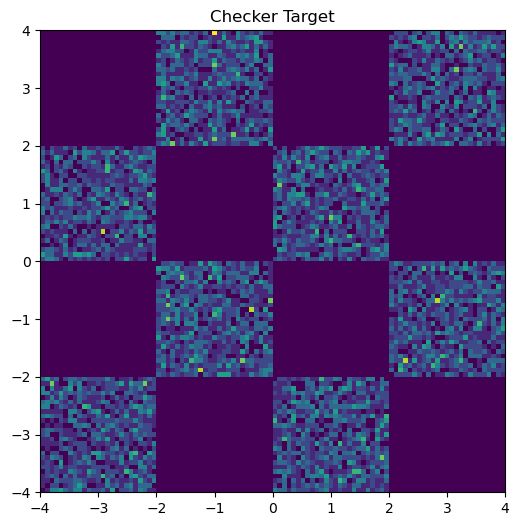

Batch Shape: (10000, 2)


In [137]:
ndim = 2
def target(bs):
    x1 = torch.rand(bs, dtype=torch.float64) * 4 - 2
    x2_ = torch.rand(bs, dtype=torch.float64) - torch.randint(2, (bs,), dtype=torch.float64) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [138]:
base_loc     = torch.zeros(ndim).to(torch.float64)
base_var     = torch.ones(ndim).to(torch.float64)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(torch.tensor(base(20000),dtype=torch.float64))









/var/folders/4g/wttxhvkx7gldjql1d48xph180000gn/T/ipykernel_99354/78688105.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_samples = grab(torch.tensor(base(20000),dtype=torch.float64))


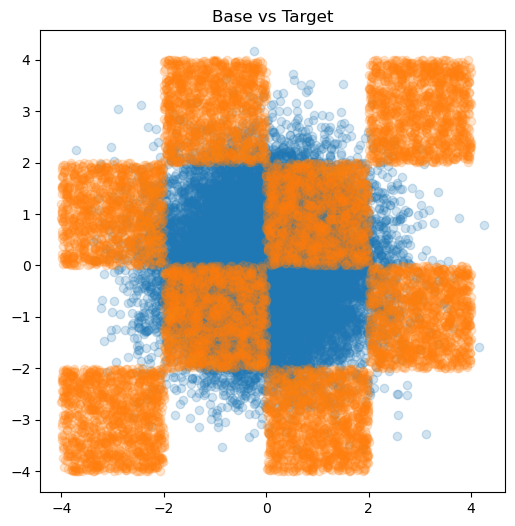

In [139]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A nonlinear interpolant.

In [140]:
path = "nonlinear"
flow_config = {
    "num_layers": 8,
    "time_embed_dim": 128,
    "hidden": 512,
    "mlp_blocks": 3,
    "activation": "gelu",
    "use_layernorm": False,
    "use_permutation": True
    }

data_type = "vector"
data_dim = 2

interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type = None,\
    flow_config=flow_config, data_type=data_type, data_dim=data_dim)

# check trainable parameters
# These should be the same object
print(f"self.It is bound to flow_model: {interpolant.It.__self__ is interpolant.flow_model}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in interpolant.flow_model.parameters())
print(f"Flow model has {trainable_params:,} trainable parameters")





self.It is bound to flow_model: True
Flow model has 4,743,184 trainable parameters


### Define losses for v

In [141]:
loss_fn_v = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-v')

### Define optimizers

In [142]:
base_lr_v      = 2e-3
base_lr_flow   = 2e-3  # learning rate for flow model (T_t)
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


v         = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_v     = torch.optim.Adam(v.parameters(), lr=base_lr_v)
opt_flow  = torch.optim.Adam(interpolant.flow_model.parameters(), lr=base_lr_flow)
sched_v   = torch.optim.lr_scheduler.StepLR(optimizer=opt_v, step_size=1500, gamma=0.4)
sched_flow = torch.optim.lr_scheduler.StepLR(optimizer=opt_flow, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 14
N_epoch      = 500
plot_bs      = 5000  # number of samples to use when plotting
bs           = 2000    # number of samples from rho_0 in batch
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]
n_inner      = 5     # number of inner minimization steps for v
n_outer      = 1     # number of outer maximization steps for flow model

if print_model:
    print("Here's the model v:", v)

In [143]:
data_dict = {
    'losses': [],
    'v_losses': [],
    'flow_losses': [],  # Changed from T_losses
    'v_grads': [],
    'flow_grads': [],   # Changed from T_grads
    'times': [],
    'logps_pflow': [],
}

counter = 1

## Training Loop with Adversarial Training

In [144]:
# Example training loop
for epoch in range(10):  # Run for a few epochs to test
    # Take a training step with adversarial training
    loss_v, loss_flow, v_grad, flow_grad = train_step(
        bs=bs,
        interpolant=interpolant,
        opt_v=opt_v,
        opt_flow=opt_flow,
        sched_v=sched_v,
        sched_flow=sched_flow,
        n_inner=n_inner,
        n_outer=n_outer
    )
    
    # Log metrics
    data_dict['v_losses'].append(grab(loss_v).mean())
    data_dict['flow_losses'].append(grab(loss_flow).mean())
    data_dict['v_grads'].append(grab(v_grad).mean())
    data_dict['flow_grads'].append(grab(flow_grad).mean())
    data_dict['losses'].append(grab(loss_v).mean())  # Use v loss as the main loss
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: v_loss={loss_v:.4f}, flow_loss={loss_flow:.4f}, v_grad={v_grad:.4f}, flow_grad={flow_grad:.4f}")
    
    counter += 1

KeyboardInterrupt: 

### Define losses for b and s

In [84]:
x0s = torch.tensor(base(bs),dtype=torch.float64)
x1s = target(bs)
ts  = torch.rand(size=(bs,))
ts[1,]


print(x0s[1:3,].view(-1,2))

interpolant.calc_xt(ts[1:3], x0s[1:3,].view(-1,2), x1s[1:3,].view(-1,2))

tensor([[-0.4746, -0.7237],
        [-0.8085, -3.4637]], dtype=torch.float64)


/var/folders/4g/wttxhvkx7gldjql1d48xph180000gn/T/ipykernel_99354/1399631382.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0s = torch.tensor(base(bs),dtype=torch.float64)


tensor([[ 0.5917, -2.8480],
        [-1.9160, -2.7661]], dtype=torch.float64, grad_fn=<CopySlices>)